In [2]:
import tensorflow as tf
import nibabel as nb
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from numpy.random import default_rng

## Global Asumptions

In [3]:
image_size=32
channels=3
batch_size = 10
width=200
augmentations = {'scale': 0.5 , 'brightness': 0.5}

## Test Dataset

In [4]:
# Cifar 10
train_dataset = (tfds.load('cifar10', split='train', as_supervised=True)
                .shuffle(buffer_size=batch_size)
                .batch(batch_size)
               )


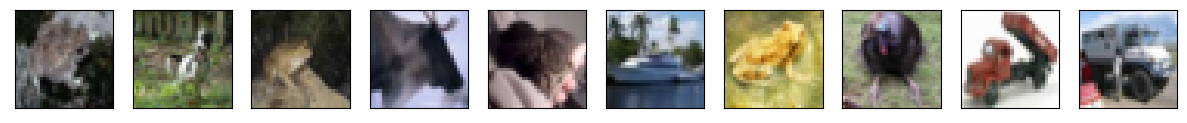

In [5]:
# Show some samples
sample = next(iter(train_dataset))[0]

plt.figure(figsize=(15, 10))
for idx, image in enumerate(sample):
    plt.subplot(1, batch_size, idx+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

plt.show()

# Augmentations:

1. Standard Normalization
2. Random scale
3. Random brightness adjust

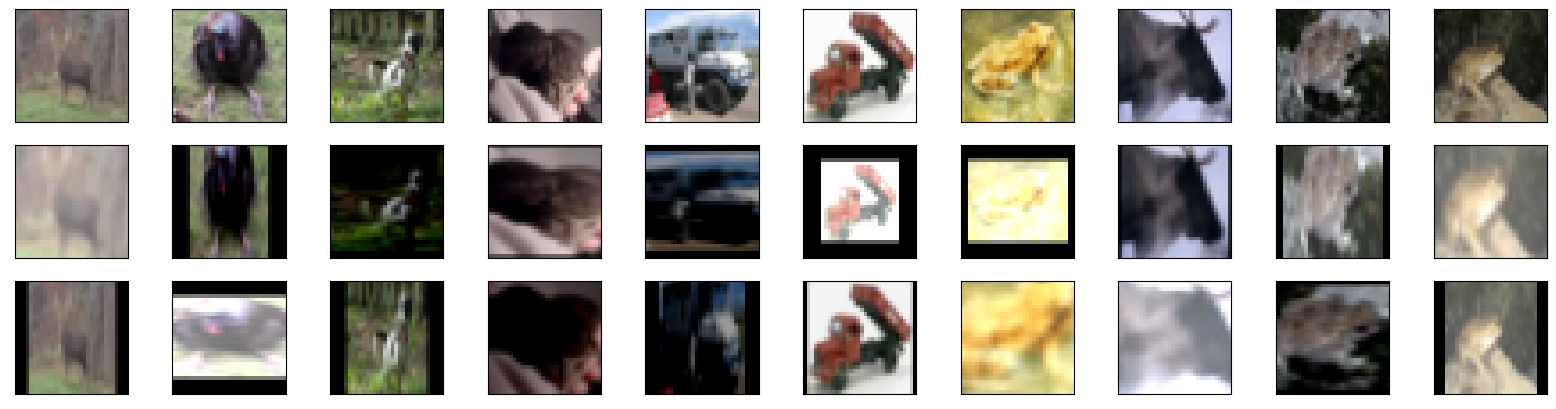

In [6]:
# Data pipeline
class Augmenter(layers.Layer):
    def __init__(self, scale, brightness, **kwargs):
        super().__init__(**kwargs)
        self.brightness = brightness
        self.scale = scale
        
        # Randon generator for brightness adjust
        self.rgen = default_rng()
        
    def get_config(self):
        config = super().get_config()
        config.update({'brightness': self.brightness, 'scale': self.scale})
        return config
    
    def call(self, images, training=True):
        
        if training:
            batch_size=images.shape[0]
            width = images.shape[1]
            height = images.shape[2]
            
            images = images/255.0
            
            # Se ecualiza la imagen y se normaliza
            #images = tfa.image.equalize(images, bins=100)
            #images = tf.image.random_brightness(images, float(self.brightness))
            #images = images / max_val
            
            """
            if not (batch_size is None):
                # Se obtienen los indices de quienes obtienen un aumento o disminucion de brillo
                positives = self.rgen.integers(low=0, high=2, size=batch_size) == 1
                negatives = positives == 0
                to_add = tf.boolean_mask(images, positives)
                to_take = tf.boolean_mask(images, negatives)
                
                brightness_var = tf.random.uniform(shape=(batch_size, 1, 1, 1), maxval=self.brightness)
                to_add = to_add + to_add * tf.boolean_mask(brightness_var, positives)
                to_take = to_take + to_take * tf.boolean_mask(brightness_var, negatives)
                
                for idx_mask, idx_real in enumerate(np.nonzero(positives)[0]):
                    images[idx_real] = to_add[idx_mask]
                    
                for idx_mask, idx_real in enumerate(np.nonzero(negatives)[0]):
                    images[idx_real] = to_take[idx_mask]
            """
            return images 

def get_augmenter(scale, brightness):
    aug = tf.keras.Sequential([
        tf.keras.Input(shape=(image_size, image_size, channels)),
        Augmenter(scale, brightness),
        layers.RandomBrightness(brightness, value_range=(0, 1)),
        layers.RandomZoom(scale, scale, fill_mode='constant')
    ])
    return aug

def augmentation_examples(num_images):    
    
    images = next((iter(train_dataset)))[0][:num_images] # Se obtienen las imagenes
    augmented = get_augmenter(**augmentations)(images)
    augmented_2 = get_augmenter(**augmentations)(images)
    
    plt.figure(figsize=(20, 5))
    for idx in range(num_images):
        plt.subplot(3, num_images, idx + 1)
        plt.imshow(images[idx])
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(3, num_images, idx + 1 + num_images)
        plt.imshow(augmented[idx])
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(3, num_images, idx + 1 + (num_images * 2))
        plt.imshow(augmented_2[idx])
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

augmentation_examples(10)
    
    

In [7]:
rgen = default_rng()
rgen.integers(low=0, high=2, size=5)

array([1, 1, 0, 1, 0])

In [8]:
# Define the encoder architecture
def get_encoder():
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(image_size, image_size, channels)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )
def get_projection_head():
    return tf.keras.Sequential(
    [
        tf.keras.Input(shape=(width,)),
        layers.Dense(width, activation='relu'),
        layers.Dense(width),
    ],
        name='projection_head'
    )

# Contrastive Loss

In [9]:
class ContrastiveModel(tf.keras.Model):
    def __init__(self, temperature):
        super().__init__()
        
        # Se definen los parametros contrastivos
        self.temperature = temperature
        
        # Metricas
        self.contrastive_loss_tracker = tf.keras.metrics.Mean(name='c_loss')
        self.contrastive_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
            name='c_acc'
        )
        
        # El modulo de aumento de datos
        self.augmenter = get_augmenter(**augmentations)
        
        self.encoder = get_encoder()
        self.projection_head = get_projection_head()
    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # Se normalizan las proyecciones
        norm_1 = tf.math.l2_normalize(projections_1, axis=1)
        norm_2 = tf.math.l2_normalize(projections_2, axis=1)

        # Se hallan las similitudes del coseno
        similarities = (
            tf.matmul(norm_1, norm_2, transpose_b=True) / self.temperature
        )
        
        batch_size = tf.shape(norm_1)[0]
        contrastive_labels = tf.range(batch_size)
        
        # Evalua la metrica de ida y de regreso
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        loss_1_2 = tf.keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = tf.keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        
        return (loss_1_2 + loss_2_1)/2
    
    def compile(self, contrastive_optimizer, **kwargs):
        super().compile(**kwargs)
        
        self.contrastive_optimizer = contrastive_optimizer
        
    def train_step(self, data):
        data = data[0]

        # Se generan los aumentos
        augmented_1 = self.augmenter(data)
        augmented_2 = self.augmenter(data)
        
        with tf.GradientTape() as tape:
            # Se generan los embebidos
            features_1 = self.encoder(augmented_1, training=True)
            features_2 = self.encoder(augmented_2, training=True)
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
            
        # Obtiene los gradientes
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        # Actualiza los pesos
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        
        self.contrastive_loss_tracker.update_state(contrastive_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        # Seems a little lonely around here, doesn't it?
        pass
        

In [10]:
baseline = ContrastiveModel(1)
baseline.compile(
    contrastive_optimizer=tf.keras.optimizers.Adam()
)
num_epochs = 5
history = baseline.fit(train_dataset, epochs=num_epochs)

Epoch 1/5


5000/5000 [==============================] - 103s 19ms/step - c_loss: 1.6592 - c_acc: 0.7861
Epoch 2/5
5000/5000 [==============================] - 96s 19ms/step - c_loss: 1.6048 - c_acc: 0.8644
Epoch 3/5
5000/5000 [==============================] - 95s 19ms/step - c_loss: 1.5924 - c_acc: 0.8850
Epoch 4/5
5000/5000 [==============================] - 95s 19ms/step - c_loss: 1.5870 - c_acc: 0.8940
Epoch 5/5
5000/5000 [==============================] - 95s 19ms/step - c_loss: 1.5821 - c_acc: 0.8981
